In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
from scipy import interpolate
import os
import sys
import astropy.units as u
import astropy.constants as c
import astropy.units as cu
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
from Corrfunc.theory import DDrppi, DD
from Corrfunc.utils import convert_rp_pi_counts_to_wp, convert_3d_counts_to_cf
sys.path.insert(0, '/work/08811/aew492/frontera/small-scale_cross-corrs')
from illustris_sim import TNGSim
import linear_theory
import photxspec
import corrfuncs
import tools

### load TNG snapshot

In [3]:
# construct SPHEREx-like galaxy samples
snapshot = 67

sigma_z = 0.03  # one of the 5 redshift error bins in SPHEREx

sim = TNGSim('TNG300-3', snapshot=snapshot)
chi = tools.redshift_to_comov(sim.redshift)
    
gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
# centered at zero
gal_pos_spec_ = gal_pos_spec - sim.boxsize / 2
assert np.all(gal_pos_spec_ >= -sim.boxsize / 2) and np.all(gal_pos_spec_ <= sim.boxsize / 2)

 number density for SPHEREx at z=0.5: 3.62e-03 (h/Mpc)^3 
target number of subhalos: 31186


### comoving distance $r\ \leftrightarrow$ angular separation $\theta$

In [4]:
# ! note redshift needs to be defined in the TNGSim earlier;
#    to use with mpl axis labels, we need a single input and dimensionless output
def theta_to_r_comov_(theta):  # theta in DEGREES
    return tools.theta_to_r_comov(theta, sim.redshift).value
def r_comov_to_theta_(r):
    return tools.r_comov_to_theta(r, sim.redshift).value

## auto-correlation

### 1. projected auto-correlation directly from Corrfunc

In [5]:
# inputs: same bins as in alternative_limber_formula20240117.ipynb for a direct comparison
randmult = 3
rpmin = 0.1
rpmax = 60
nrpbins = 10
pimax = int(0.8 * sim.boxsize.value) # max depth to integrate along LOS
nthreads = 10
periodic = False
nrepeats = 10  # how many times to repeat computation to help with noise / numerical errors ?

In [6]:
# compute the projected auto-correlation function

# prep data
data_for_cf = corrfuncs.set_up_cf_data(gal_pos_spec, randmult=randmult, rmin=rpmin, rmax=rpmax, nbins=nrpbins,
                                  boxsize=sim.boxsize, logbins=True)
rp_edges, rp_avg, nd, _, boxsize, nr, rand_set, data_set, _ = data_for_cf.values()
assert np.allclose(boxsize, sim.boxsize.value)
assert np.all(rand_set >= 0) and np.all(rand_set <= boxsize)
assert np.all(data_set >= 0) and np.all(data_set <= boxsize)

# unpack
xd, yd, zd = data_set.T
xr, yr, zr = rand_set.T

wps = np.full((nrepeats,nrpbins), np.nan)
for j in range(nrepeats):

    dd_res = DDrppi(1, nthreads, pimax, rp_edges, xd, yd, zd, boxsize=boxsize, periodic=periodic, output_rpavg=True)
    dr_res = DDrppi(0, nthreads, pimax, rp_edges, xd, yd, zd, X2=xr, Y2=yr, Z2=zr, boxsize=boxsize, periodic=periodic)
    rr_res = DDrppi(1, nthreads, pimax, rp_edges, xr, yr, zr, boxsize=boxsize, periodic=periodic)

    # turn pair counts into actual correlation function: Landy-Szalay estimator
    wps[j] = convert_rp_pi_counts_to_wp(nd, nd, nr, nr, dd_res, dr_res, dr_res, rr_res, nrpbins, pimax)

wp = np.nanmean(wps, axis=0)  # get the mean across the runs

In [7]:
wp

array([372.46957653, 168.44340895,  85.98845386,  55.51458183,
        40.97657519,  25.50438223,  12.0057699 ,   5.8179458 ,
         1.25819515,  -1.60164789])

### 2. compute out $w_p(r_p)$ directly from the pair counts

$$
w_p(r_p) = \int \mathrm{d}x_p\,\xi\left(\sqrt{x^2_p + x^2_\perp}\right)
$$

This is effectively copying out what happens in `convert_rp_pi_counts_to_wp`.

In [8]:
# compute the pair counts
dd_res = DDrppi(1, nthreads, pimax, rp_edges, xd, yd, zd, boxsize=boxsize, periodic=periodic, output_rpavg=True)
dr_res = DDrppi(0, nthreads, pimax, rp_edges, xd, yd, zd, X2=xr, Y2=yr, Z2=zr, boxsize=boxsize, periodic=periodic)
rr_res = DDrppi(1, nthreads, pimax, rp_edges, xr, yr, zr, boxsize=boxsize, periodic=periodic)

# turn pair counts into xi(rp,pi)
xirppi_unrolled = convert_3d_counts_to_cf(nd, nd, nr, nr, dd_res, dr_res, dr_res, rr_res)
xirppi_unrolled.shape  # this is xi(rp,pi) unrolled to 1D

(1640,)

In [9]:
npibins = len(xirppi_unrolled) // nrpbins  # how many bins along the LOS
xirppi = np.reshape(xirppi_unrolled, (nrpbins,npibins))  # "roll up" the 1D array to 2D (rp,pi)

Text(0.5, 1.0, '$\\xi(r_p,\\pi)$, Spectroscopic galaxies from TNG ($z=$0.5)')

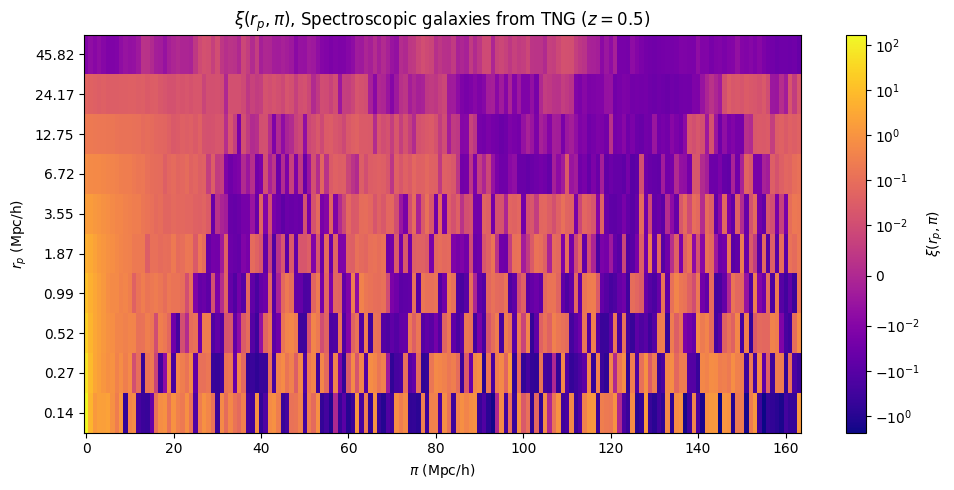

In [10]:
# plot this 2D xi(rp,pi)
norm = mpl.colors.SymLogNorm(1e-2)
fig, ax = plt.subplots(figsize=(10,5), tight_layout=True)
im = ax.imshow(xirppi, origin='lower', norm=norm, cmap='plasma', aspect='auto')
fig.colorbar(im, ax=ax, label=r'$\xi(r_p,\pi)$')
rp_labels = [f'{rp:.2f}' for rp in rp_avg]
ax.set_yticks(np.arange(nrpbins), labels=rp_labels)
ax.set_xlabel(r'$\pi$ (Mpc/h)')
ax.set_ylabel(r'$r_p$ (Mpc/h)')
ax.set_title(r'$\xi(r_p,\pi)$, Spectroscopic galaxies from TNG ($z=$'f'{sim.redshift})')

In [11]:
# sum over pi / r_parallel to get 1D wp(rp)
dpi = 1.  # Corrfunc uses unity resolution along LOS
wp1 = np.array([
    2.0 * dpi * np.nansum(xirp) for xirp in xirppi  # NANsum -> Corrfunc.convert_rp_pi_counts_to_wp uses np.sum
])
wp1

array([372.46957653, 168.44340895,  85.98845386,  55.51458183,
        40.97657519,  25.50438223,  12.0057699 ,   5.8179458 ,
         1.25819515,  -1.60164789])

In [12]:
# sum over pi / r_parallel to get 1D wp(rp)
pi_edges = np.linspace(0, pimax, npibins+1)
piavg = 0.5 * (pi_edges[1:] + pi_edges[:-1])
wp2 = 2.0 * integrate.trapz(xirppi, x=piavg, axis=1)
wp2

array([203.12197379, 108.69423745,  61.43971899,  44.37361766,
        36.0928798 ,  23.53890917,  11.228546  ,   5.568122  ,
         1.18833817,  -1.54555333])

In [13]:
# sum over pi / r_parallel to get 1D wp(rp)
pi_edges = np.linspace(0, pimax, npibins+1)
piavg = 0.5 * (pi_edges[1:] + pi_edges[:-1])
wp3 = 2.0 * integrate.simpson(xirppi, x=piavg, axis=1)
wp3

array([175.82136601, 100.10607742,  58.41617037,  43.29434202,
        35.8711561 ,  23.51072034,  11.213257  ,   5.56621108,
         1.18506555,  -1.54244376])

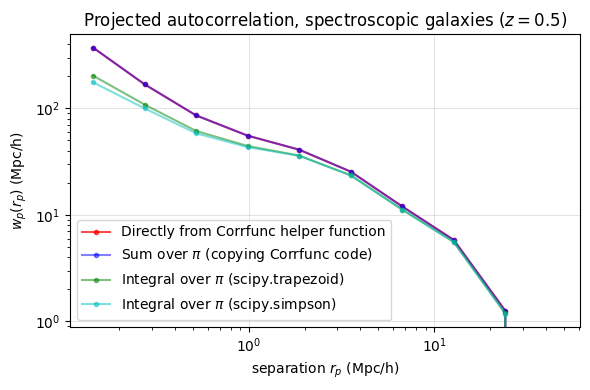

In [14]:
# compare the direct output from Corrfunc and my own sum over pi
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)

ax.plot(rp_avg, wp, marker='.', alpha=0.7, c='r', label='Directly from Corrfunc helper function')
ax.plot(rp_avg, wp1, marker='.', alpha=0.5, c='b', label=r'Sum over $\pi$ (copying Corrfunc code)')
ax.plot(rp_avg, wp2, marker='.', alpha=0.5, c='g', label=r'Integral over $\pi$ (scipy.trapezoid)')
ax.plot(rp_avg, wp3, marker='.', alpha=0.5, c='c', label=r'Integral over $\pi$ (scipy.simpson)')
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$ (Mpc/h)')
ax.set_title(f"Projected autocorrelation, spectroscopic galaxies ("r"$z=$"f"{sim.redshift})")
ax.legend()

### 3. compare to $w_p(r_p)$ computed from $\xi(r)$ $\rightarrow$ assumes isotropy

The projected correlation function is
$$
w_p(r_p) = \int_{-\infty}^\infty \xi(r_p,r_\pi)\,\mathrm{d}r_\pi
$$

(from van den Bosch's LSS slides: http://www.astro.yale.edu/vdbosch/astro610_lecture12.pdf)

Similarly, from Adam,
$$
w(r_p) = \int \mathrm{d}r_{||}\,\xi\left(\sqrt{r^2_{||} + r^2_p}\right)
$$

where $r\equiv\sqrt{r^2_{||} + r^2_p}$

In [15]:
# inputs: same bins as in alternative_limber_formula20240117.ipynb for a direct comparison
randmult = 3
rmin = 0.1
rmax = 100
nbins = 10
pimax = int(sim.boxsize.value) # max depth to integrate along LOS
nthreads = 10
periodic = False
nrepeats = 10  # how many times to repeat computation to help with noise / numerical errors ?

In [16]:
# compute the pair counts

# prep data
data_for_cf = corrfuncs.set_up_cf_data(gal_pos_spec, randmult=randmult, rmin=rmin, rmax=rmax, nbins=nbins,
                                  boxsize=sim.boxsize, logbins=True)
r_edges, r_avg, nd, _, boxsize, nr, rand_set, data_set, _ = data_for_cf.values()
assert np.allclose(boxsize, sim.boxsize.value)
assert np.all(rand_set >= 0) and np.all(rand_set <= boxsize)
assert np.all(data_set >= 0) and np.all(data_set <= boxsize)

# unpack
xd, yd, zd = data_set.T
xr, yr, zr = rand_set.T

xis = np.full((nrepeats,nbins), np.nan)

for j in range(nrepeats):

    dd_res = DD(1, nthreads, r_edges, xd, yd, zd, boxsize=boxsize, periodic=periodic, output_ravg=True)
    dr_res = DD(0, nthreads, r_edges, xd, yd, zd, X2=xr, Y2=yr, Z2=zr, boxsize=boxsize, periodic=periodic)
    rr_res = DD(1, nthreads, r_edges, xr, yr, zr, boxsize=boxsize, periodic=periodic)

    # turn pair counts into actual correlation function: Landy-Szalay estimator
    xis[j] = convert_3d_counts_to_cf(nd, nd, nr, nr, dd_res, dr_res, dr_res, rr_res)

xi = np.nanmean(xis, axis=0)  # get the mean across the runs

/work/08811/aew492/frontera/small-scale_cross-corrs/linear_theory.py:71: RuntimeWarning: Mean of empty slice
  bias = np.nanmean(ratio[bias_range[0]:bias_range[1]])


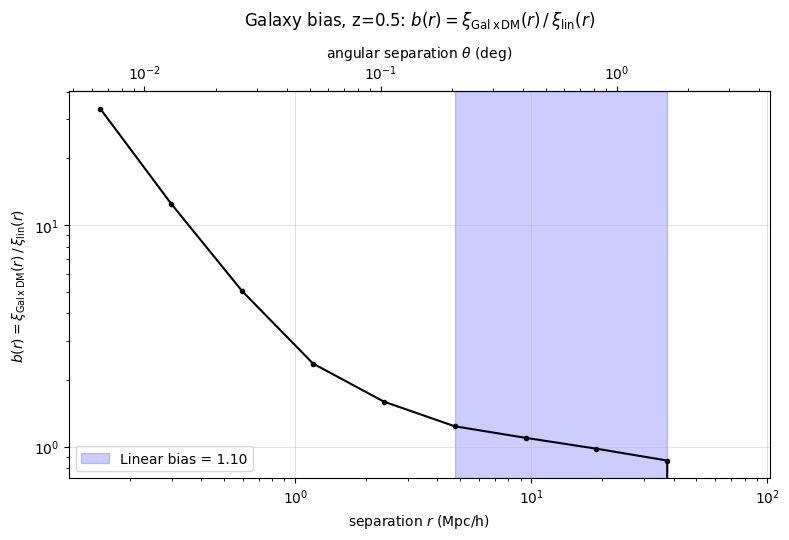

In [17]:
# compare to linear theory
xi_lin_dm = tools.linear_2pcf(sim.redshift, r_avg)

# get linear bias from spectroscopic sample
_, ratio = linear_theory.get_linear_bias(gal_pos_spec, sim, r_edges=r_edges, return_ratio=True)

# range to compute linear bias
biasrange = (-5,-2) # indices from ravg
bias = np.mean(ratio[biasrange[0]:biasrange[1]])

fig, ax = plt.subplots(figsize=(8,5.5), tight_layout=True)
ax.plot(r_avg, ratio, 'k.-')
secax = ax.secondary_xaxis('top', functions=(r_comov_to_theta_, theta_to_r_comov_))
secax.set_xlabel(r'angular separation $\theta$ (deg)')
ax.axvspan(r_avg[-5], r_avg[-2], color='b', alpha=0.2, label=f'Linear bias = {bias:.2f}')
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$b(r) = \xi_\mathrm{Gal\,x\,DM}(r)\,/\,\xi_\mathrm{lin}(r)$')
ax.set_title(f'Galaxy bias, z={sim.redshift}: 'r'$b(r) = \xi_\mathrm{Gal\,x\,DM}(r)\,/\,\xi_\mathrm{lin}(r)$', y=1.15)
ax.legend()

In [18]:
# galaxy c.f. is the matter c.f. times the bias squared
xi_lin = bias**2 * xi_lin_dm

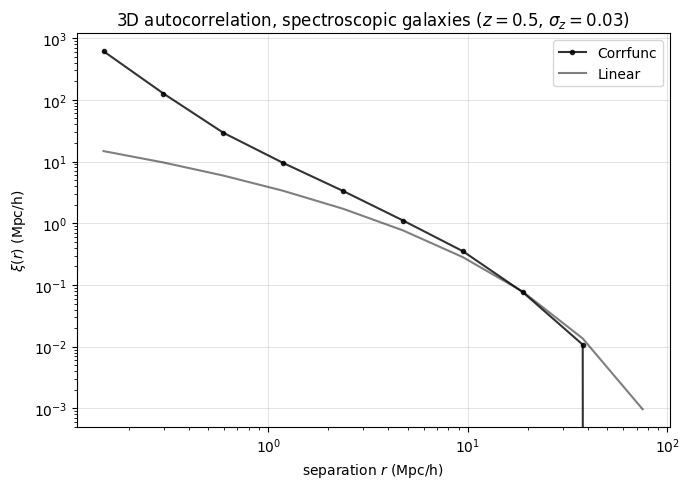

In [19]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

ax.plot(r_avg, xi, marker='.', alpha=0.8, c='k', label='Corrfunc' )
ax.plot(r_avg, xi_lin, 'k-', alpha=0.5, label='Linear')
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$ (Mpc/h)')
ax.set_title(f"3D autocorrelation, spectroscopic galaxies ("r"$z=$" + 
             f"{sim.redshift}, "r"$\sigma_z=$"f"{sigma_z})")
ax.legend()

In [20]:
# use these as a lookup table to interpolate (rp,pi)
#  also plot to keep track of where the interpolated points land
rp = rp_avg
pi = rp_avg  # also use rp_avg

# populate 2D array of separation r from each (r_p, pi) pair
r_arr = np.empty((len(rp), len(pi)))
for i, rp_ in enumerate(rp):
    for j, pi_ in enumerate(pi):
        r_arr[i,j] = np.sqrt(rp_**2 + pi_**2)
        if r_arr[i,j] > max(r_avg):
            print(f"r to evaluate ({r_arr[i,j]:.3f} Mpc/h) is greater than max r_avg ({max(r_avg):.3f})!")
            continue

# interpolate xi(r) on this r_arr grid
xi_arr = np.exp(np.interp(np.log(r_arr), np.log(r_avg), np.log(xi)))
xi_lin_arr = np.exp(np.interp(np.log(r_arr), np.log(r_avg), np.log(xi_lin)))

/work/08811/aew492/frontera/venv/illustris/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  


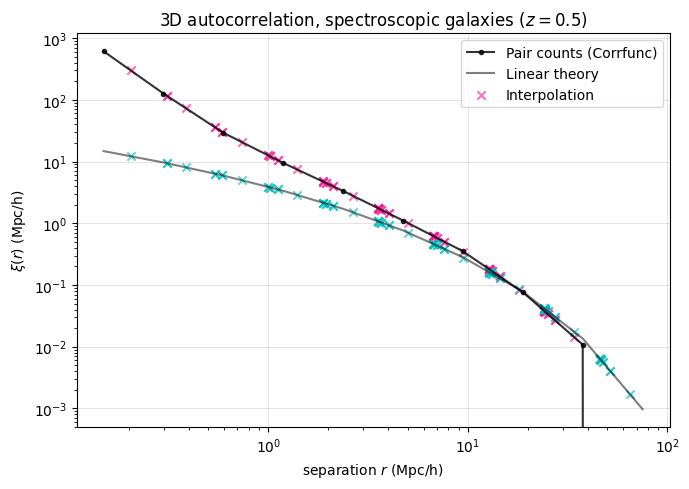

In [21]:
# plot
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

ax.plot(r_avg, xi, marker='.', alpha=0.8, c='k', label='Pair counts (Corrfunc)')
ax.plot(r_avg, xi_lin, 'k-', alpha=0.5, label='Linear theory')

ax.scatter(r_arr, xi_arr, c='deeppink', marker='x', alpha=0.6, label='Interpolation')
ax.scatter(r_arr, xi_lin_arr, c='c', marker='x', alpha=0.6)

ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$ (Mpc/h)')
ax.set_title(f"3D autocorrelation, spectroscopic galaxies ("r"$z=$"f"{sim.redshift})")
ax.legend()

Text(0.5, 1.0, '$\\xi(r_p,\\pi)$, Spectroscopic galaxies from TNG ($z=$0.5), from isotropic $\\xi(r)$')

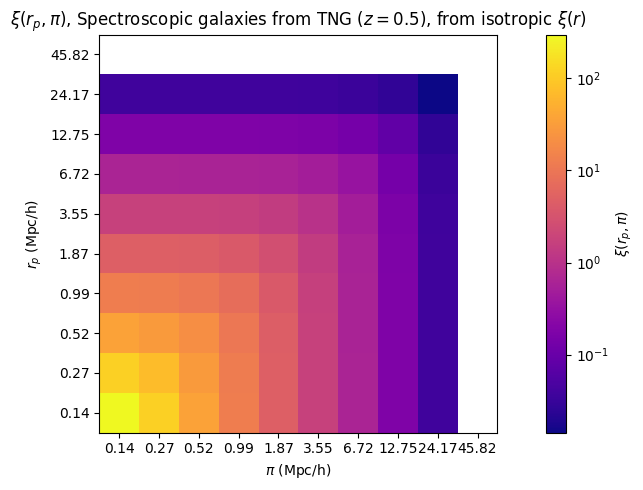

In [22]:
# plot this 2D xi(rp,pi)
norm = mpl.colors.SymLogNorm(1e-2)
fig, ax = plt.subplots(figsize=(10,5), tight_layout=True)
im = ax.imshow(xi_arr, origin='lower', norm=norm, cmap='plasma')
fig.colorbar(im, ax=ax, label=r'$\xi(r_p,\pi)$')
pi_labels = [f'{x:.2f}' for x in pi]
ax.set_xticks(np.arange(nbins), labels=pi_labels)
rp_labels = [f'{x:.2f}' for x in rp]
ax.set_yticks(np.arange(nbins), labels=rp_labels)
ax.set_xlabel(r'$\pi$ (Mpc/h)')
ax.set_ylabel(r'$r_p$ (Mpc/h)')
ax.set_title(r'$\xi(r_p,\pi)$, Spectroscopic galaxies from TNG ($z=$'f'{sim.redshift}), from isotropic 'r'$\xi(r)$')

In [23]:
# sum over pi / r_parallel to get 1D wp(rp)
# !! manually inserting -1 index to avoid NaNs (where xi went negative)
wp_isotropic = 2.0 * integrate.trapz(xi_arr[:-1,:-1], x=pi[:-1], axis=0)
wp_isotropic = np.append(wp_isotropic, np.nan)
wp_lin_isotropic = 2.0 * integrate.trapz(xi_lin_arr, x=pi, axis=0)

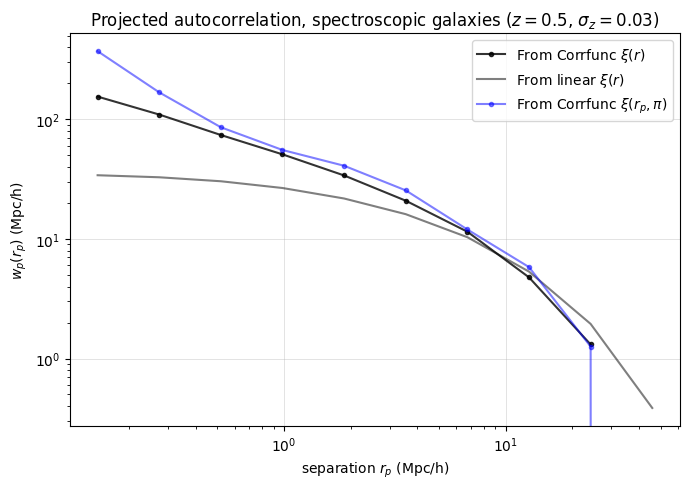

In [24]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

ax.plot(rp, wp_isotropic, marker='.', alpha=0.8, c='k', label=r'From Corrfunc $\xi(r)$')
ax.plot(rp, wp_lin_isotropic, alpha=0.5, c='k', label=r'From linear $\xi(r)$')
ax.plot(rp_avg, wp1, marker='.', alpha=0.5, c='b', label=r'From Corrfunc $\xi(r_p,\pi)$')
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$ (Mpc/h)')
ax.set_title(f"Projected autocorrelation, spectroscopic galaxies ("r"$z=$"f"{sim.redshift}, " +
             r"$\sigma_z=$"f"{sigma_z})")
ax.legend()

Text(0.5, 1.0, 'Ratio between $w_p$ from $\\xi(r_p,\\pi)$ and $w_p$ from $\\xi(r)$')

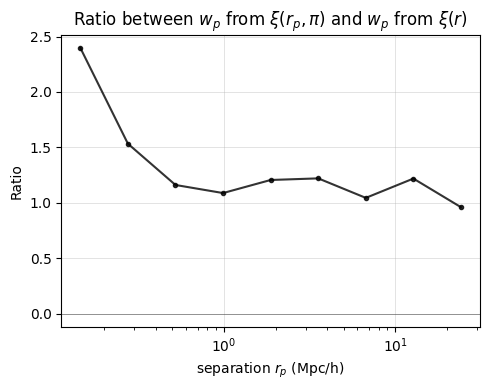

In [25]:
# plot the ratio to understand a bit better
ratio = wp1 / wp_isotropic

fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)

ax.plot(rp, ratio, marker='.', alpha=0.8, c='k')
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.semilogx()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'Ratio')
ax.set_title(r"Ratio between $w_p$ from $\xi(r_p,\pi)$ and $w_p$ from $\xi(r)$")

### impact of $\pi_\mathrm{max}$ on $\xi(r_p,\pi)$

In [26]:
pimaxes = np.linspace(10, sim.boxsize.value, 5).astype(int)

# prep data
data_for_cf = corrfuncs.set_up_cf_data(gal_pos_spec, randmult=randmult, rmin=rpmin, rmax=rpmax, nbins=nrpbins,
                                  boxsize=sim.boxsize, logbins=True)
rp_edges, rp_avg, nd, _, boxsize, nr, rand_set, data_set, _ = data_for_cf.values()
# unpack
xd, yd, zd = data_set.T
xr, yr, zr = rand_set.T

wps = np.empty((len(pimaxes), nrpbins))
for i, pimax_ in enumerate(pimaxes):
    # compute the projected auto-correlation function

    wps_ = np.full((nrepeats,nrpbins), np.nan)
    for j in range(nrepeats):

        dd_res = DDrppi(1, nthreads, pimax_, rp_edges, xd, yd, zd, boxsize=boxsize, periodic=periodic, output_rpavg=True)
        dr_res = DDrppi(0, nthreads, pimax_, rp_edges, xd, yd, zd, X2=xr, Y2=yr, Z2=zr, boxsize=boxsize, periodic=periodic)
        rr_res = DDrppi(1, nthreads, pimax_, rp_edges, xr, yr, zr, boxsize=boxsize, periodic=periodic)

        # turn pair counts into actual correlation function: Landy-Szalay estimator
        wps_[j] = convert_rp_pi_counts_to_wp(nd, nd, nr, nr, dd_res, dr_res, dr_res, rr_res, nrpbins, pimax_)

    wps[i] = np.nanmean(wps_, axis=0)  # get the mean across the runs

/work/08811/aew492/frontera/venv/illustris/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


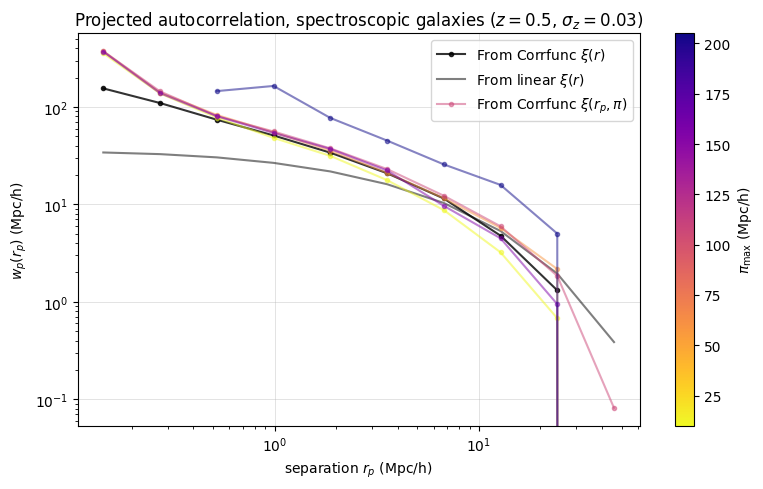

In [27]:
norm = mpl.colors.Normalize(vmin=min(pimaxes), vmax=max(pimaxes))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='plasma_r')

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)

ax.plot(rp, wp_isotropic, marker='.', alpha=0.8, c='k', label=r'From Corrfunc $\xi(r)$')
ax.plot(rp, wp_lin_isotropic, alpha=0.5, c='k', label=r'From linear $\xi(r)$')
for i, wp_ in enumerate(wps):
    label = r'From Corrfunc $\xi(r_p,\pi)$' if i == len(wps)//2 else ''
    ax.plot(rp_avg, wp_, marker='.', alpha=0.5, c=smap.to_rgba(pimaxes[i]),
            label=label)
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$ (Mpc/h)')
ax.set_title(f"Projected autocorrelation, spectroscopic galaxies ("r"$z=$" +
             f"{sim.redshift}, "r"$\sigma_z=$"f"{sigma_z})")
fig.colorbar(smap, ax=ax, label=r'$\pi_\mathrm{max}$ (Mpc/h)')
ax.legend()

## cross-correlation with photometric sample

In [28]:
# construct photometric sample
dx = tools.get_dx(sim.redshift, sigma_z)
gal_pos_phot = photxspec.construct_photometric_sample(gal_pos_spec, dx, mean=sim.boxsize/2)
# centered at zero
gal_pos_phot_ = gal_pos_phot - sim.boxsize / 2
assert np.all(gal_pos_phot_ >= -sim.boxsize / 2) and np.all(gal_pos_phot_ <= sim.boxsize / 2)

# divide the spectroscopic sample into slices along the LOS
nslices = 11
losbins = np.linspace(-sim.boxsize.value/2, sim.boxsize.value/2, nslices+1) << sim.boxsize.unit
slicewidth = (losbins[1]-losbins[0])
slice_centers = np.array([(losbins[i].value+losbins[i+1].value)/2 for i in range(nslices)]) << sim.boxsize.unit
slices_spec = [
    gal_pos_spec_[(losbins[i] <= gal_pos_spec_[:,2]) & (gal_pos_spec_[:,2] < losbins[i+1])] \
    for i in range(nslices)
]

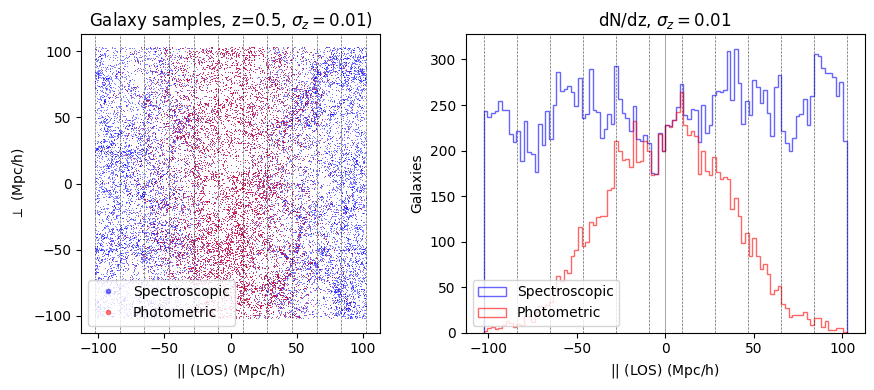

In [29]:
# check out the distributions along the LOS (== z /[:,2] component)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4), tight_layout=True)
kwargs = dict(marker=',', alpha=0.5, ls='None')
ax0.plot(gal_pos_spec_[:,2], gal_pos_spec_[:,0], c='b', **kwargs)
ax0.plot(gal_pos_phot_[:,2], gal_pos_phot_[:,0], c='r', **kwargs)
legend_elements = [mpl.lines.Line2D([0], [0], marker='.', ls='None', c='b', alpha=0.5, label='Spectroscopic'),
                   mpl.lines.Line2D([0], [0], marker='.', ls='None', c='r', alpha=0.5, label='Photometric')]
ax0.set_aspect('equal')
ax0.set_xlabel(r'$||$ (LOS) (Mpc/h)')
ax0.set_ylabel(r'$\perp$ (Mpc/h)')
ax0.legend(handles=legend_elements)
ax0.set_title(f'Galaxy samples, z={sim.redshift}, 'r'$\sigma_z=$'f'{sigma_z})')

kwargs = dict(histtype='step', alpha=0.6)
_, bins, _ = ax1.hist(gal_pos_spec_[:,2].value, bins=100, color='b', label='Spectroscopic', **kwargs)
_, _, _ = ax1.hist(gal_pos_phot_[:,2].value, bins=bins, color='r', label='Photometric', **kwargs)
ax1.axvline(0, alpha=0.5, c='k', lw=0.5)
ax1.set_xlabel(r'$||$ (LOS) (Mpc/h)')
ax1.set_ylabel('Galaxies')
ax1.legend(loc=3)
ax1.set_title(r'dN/dz, $\sigma_z=$'f'{sigma_z}')

for ax in (ax0, ax1):
    for x in losbins:
        ax.axvline(x.value, alpha=0.6, c='k', lw=0.5, ls='--')

### 1. projected cross-correlation directly from Corrfunc

In [30]:
# compute cross-correlation

# inputs: same as above with the auto except redefine pimax!
pimax = sim.boxsize.value // 2

# compute the projected auto-correlation function

# prep data
data_for_cf = corrfuncs.set_up_cf_data(gal_pos_phot, randmult=randmult, rmin=rpmin, rmax=rpmax, nbins=nrpbins,
                                       data2=gal_pos_spec, boxsize=sim.boxsize, logbins=True)
rp_edges, rp_avg, nd1, nd2, boxsize, nr, rand_set, data1_set, data2_set = data_for_cf.values()
assert np.allclose(boxsize, sim.boxsize.value)
assert np.all(rand_set >= 0) and np.all(rand_set <= boxsize)
assert np.all(data1_set >= 0) and np.all(data1_set <= boxsize)
assert np.all(data2_set >= 0) and np.all(data2_set <= boxsize)

# unpack
xd1, yd1, zd1 = data1_set.T
xd2, yd2, zd2 = data2_set.T
xr, yr, zr = rand_set.T

wps = np.full((nrepeats,nrpbins), np.nan)
for j in range(nrepeats):

    d1d2_res = DDrppi(0, nthreads, pimax, rp_edges, xd1, yd1, zd1, X2=xd2, Y2=yd2, Z2=zd2,
                      boxsize=boxsize, periodic=periodic, output_rpavg=True)
    d1r_res = DDrppi(0, nthreads, pimax, rp_edges, xd1, yd1, zd1, X2=xr, Y2=yr, Z2=zr,
                      boxsize=boxsize, periodic=periodic)
    d2r_res = DDrppi(0, nthreads, pimax, rp_edges, xd2, yd2, zd2, X2=xr, Y2=yr, Z2=zr,
                      boxsize=boxsize, periodic=periodic)
    rr_res = DDrppi(1, nthreads, pimax, rp_edges, xr, yr, zr, boxsize=boxsize, periodic=periodic)

    # turn pair counts into actual correlation function: Landy-Szalay estimator
    wps[j] = convert_rp_pi_counts_to_wp(nd1, nd2, nr, nr, d1d2_res, d1r_res, d2r_res, rr_res, nrpbins, pimax)

wpx = np.nanmean(wps, axis=0)  # get the mean across the runs

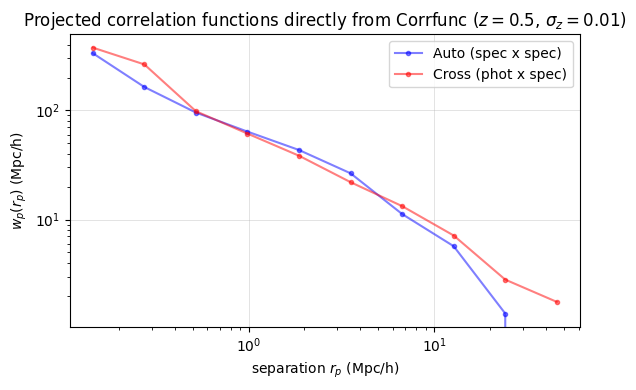

In [31]:
# compare to the auto-correlation
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)

ax.plot(rp_avg, wp, marker='.', alpha=0.5, c='b', label='Auto (spec x spec)')
ax.plot(rp_avg, wpx, marker='.', alpha=0.5, c='r', label=r'Cross (phot x spec)')
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$ (Mpc/h)')
ax.set_title(f"Projected correlation functions directly from Corrfunc ("r"$z=$"f"{sim.redshift}, " + 
             r"$\sigma_z=$"f"{sigma_z})")
ax.legend()

$\rightarrow$ almost identical, as expected! since we're not dividing the spectroscopic sample into $\delta z_i$ bins

#### in spectroscopic LOS bins

In [ ]:
# create nslices samples by shifting and wrapping the LOS positions around the box
gal_pos_specs = np.empty((nslices, len(gal_pos_spec), 3))
for i in range(nslices):
    # first, shift everything by i * slicewidth
    gal_pos_spec_shifted = np.copy(gal_pos_spec_)
    gal_pos_spec_shifted[:,2] += i * slicewidth << gal_pos_spec_shifted.unit
    # wrap any galaxies outside the box
    idx_to_wrap = (gal_pos_spec_shifted[:,2] >= sim.boxsize / 2)
    gal_pos_spec_shifted[:,2][idx_to_wrap] -= sim.boxsize
    gal_pos_specs[i] = gal_pos_spec_shifted

gal_pos_phots = [
        photxspec.construct_photometric_sample(gal_pos_spec__ << dx.unit, dx) for gal_pos_spec__ in gal_pos_specs
]

In [ ]:
fig = plt.figure(figsize=(16,12), tight_layout=True)
kwargs = dict(marker=',', alpha=0.5, ls='None')

wpxs = np.full((nslices,nslices,nrpbins), np.nan)  # one set of wpx for each spectroscopic sample
wpxs = []
for i, spec_sample in enumerate(gal_pos_specs):
    print(f"{(i+1)/len(gal_pos_specs)*100:.0f}%\t", end='\r')
    
    # divide the spectroscopic sample and corresponding photometric sample into slices
    slices_spec = [
        spec_sample[(losbins.value[i] <= spec_sample[:,2]) & (spec_sample[:,2] < losbins.value[i+1])] \
        for i in range(nslices)
    ]
    
    wpx_thissample = np.full((nslices,nrpbins), np.nan)
    for j, spec_slice in enumerate(slices_spec):
        
        # prep data
        data_for_cf = corrfuncs.set_up_cf_data(spec_slice, randmult=randmult, rmin=rpmin, rmax=rpmax, nbins=nrpbins,
                                               data2=gal_pos_phots[i], boxsize=sim.boxsize, logbins=True)
        rp_edges, rp_avg, nd1, nd2, boxsize, nr, rand_set, data1_set, data2_set = data_for_cf.values()
        assert np.allclose(boxsize, sim.boxsize.value)
        assert np.all(rand_set >= 0) and np.all(rand_set <= boxsize)
        assert np.all(data1_set >= 0) and np.all(data1_set <= boxsize)
        assert np.all(data2_set >= 0) and np.all(data2_set <= boxsize)

        # PLOT
        if i==0:
            ax = fig.add_subplot(3, 4, j+1)
            ax.plot(data2_set[:,2], data2_set[:,0], c='r', **kwargs)
            ax.plot(data1_set[:,2], data1_set[:,0], c='b', **kwargs)
            ax.axhline(0, c='k', lw=0.5, alpha=0.5)
            ax.axvline(0, c='k', lw=0.5, alpha=0.5)
            ax.set_aspect('equal')
            ax.set_xlabel('|| (Mpc/h)')
            ax.set_ylabel(r'$\perp$ (Mpc/h)')
            ax.set_title(f'Spec slice {j+1} of {nslices}')

        # unpack
        xd1, yd1, zd1 = data1_set.T
        xd2, yd2, zd2 = data2_set.T
        xr, yr, zr = rand_set.T

        wps_thisslice = np.full((nrepeats,nrpbins), np.nan)
        pimax_ = 180.
        for k in range(nrepeats):

            d1d2_res = DDrppi(0, nthreads, pimax_, rp_edges, xd1, yd1, zd1, X2=xd2, Y2=yd2, Z2=zd2,
                              boxsize=boxsize, periodic=periodic, output_rpavg=True)
            d1r_res = DDrppi(0, nthreads, pimax_, rp_edges, xd1, yd1, zd1, X2=xr, Y2=yr, Z2=zr,
                              boxsize=boxsize, periodic=periodic)
            d2r_res = DDrppi(0, nthreads, pimax_, rp_edges, xd2, yd2, zd2, X2=xr, Y2=yr, Z2=zr,
                              boxsize=boxsize, periodic=periodic)
            rr_res = DDrppi(1, nthreads, pimax_, rp_edges, xr, yr, zr, boxsize=boxsize, periodic=periodic)

            # turn pair counts into actual correlation function: Landy-Szalay estimator
            wps_thisslice[k] = convert_rp_pi_counts_to_wp(nd1, nd2, nr, nr,
                                                          d1d2_res, d1r_res, d2r_res, rr_res, nrpbins, pimax_)

        wpx_thissample[j] = np.nanmean(wps_thisslice, axis=0)  # get the mean across the runs
    wpxs.append(wpx_thissample)